<a href="https://colab.research.google.com/github/jsansao/AprendizadoReforco/blob/main/Licao3_DQN_Pong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# CELL 1: Install Dependencies
# Run this cell to install all necessary packages for the Colab environment.
!pip install gymnasium[atari,accept-rom-license]
!pip install torch
!pip install pyvirtualdisplay
!pip install moviepy

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple, deque
from itertools import count
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# For rendering in Colab
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import moviepy.editor as mpy
import ale_py

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [ ]:
# CELL 3: Setup Virtual Display for Colab
# This is necessary to show videos of the game being played.
display = Display(visible=0, size=(400, 300))
display.start()

# Set up matplotlib for plotting
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Use CUDA (GPU) if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# CELL 4: Replay Memory (Replay Buffer)
# A crucial component of DQN. It stores transitions (state, action, next_state, reward)
# so the agent can learn from a decorrelated batch of past experiences.

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    """A finite-sized circular buffer to store experience tuples."""
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Select a random batch of transitions for training"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Return the current size of the memory"""
        return len(self.memory)

In [ ]:
# CELL 5: DQN Model (Convolutional Neural Network)
# This is the neural network that learns the Q-values.
# It takes 4 stacked, preprocessed game frames as input and
# outputs the estimated Q-value for each possible action.

class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        # Input shape: (Batch_size, 4, 84, 84)
        # 4 stacked grayscale frames of 84x84 pixels
        self.conv_stack = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),  # (84-8)/4 + 1 = 20
            nn.ReLU(),
            # Output: (Batch_size, 32, 20, 20)
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # (20-4)/2 + 1 = 9
            nn.ReLU(),
            # Output: (Batch_size, 64, 9, 9)
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # (9-3)/1 + 1 = 7
            nn.ReLU()
            # Output: (Batch_size, 64, 7, 7)
        )

        # Fully connected layers
        self.fc_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        # The input x is on a 0-255 scale. We scale it to 0-1.
        x = x.float() / 255.0
        x = self.conv_stack(x)
        return self.fc_stack(x)

In [ ]:
# CELL 6: Create Environment
# We use wrappers from gymnasium to do all the preprocessing:
# 1. AtariPreprocessing: Grayscales, resizes (84x84), and frame-skips.
# 2. FrameStack: Stacks 4 consecutive frames together.

def create_env(render_mode=None):
    env = gym.make("ALE/Pong-v5", frameskip=1, render_mode=render_mode)
    # Apply standard Atari preprocessing
    env = gym.wrappers.AtariPreprocessing(env, scale_obs=False)
    # Stack 4 frames
    env = gym.wrappers.FrameStackObservation(env, 4)
    return env

env = create_env()

# Get number of actions from gym
n_actions = env.action_space.n
# Get the shape of the observation (state)
state, _ = env.reset()
n_observations = state.shape
print(f"Number of actions: {n_actions}")
print(f"Observation shape: {n_observations}")

Number of actions: 6
Observation shape: (4, 84, 84)


In [ ]:
# CELL 7: Hyperparameters & Agent Setup

# --- Hyperparameters ---
BATCH_SIZE = 32         # Number of transitions sampled from memory
GAMMA = 0.99            # Discount factor
EPS_START = 1.0         # Starting value of epsilon (exploration)
EPS_END = 0.01          # Minimum value of epsilon
EPS_DECAY = 1_000_000   # Controls the rate of exponential decay of epsilon
TAU = 0.005             # Update rate for the target network
LR = 1e-4               # Learning rate for the optimizer
MEMORY_CAPACITY = 100_000 # Size of the replay buffer
TRAIN_START = 10_000    # Number of steps to fill memory before training
TARGET_UPDATE = 1_000   # How often (in steps) to update the target network

# --- Agent Components ---
# We create two networks:
# 1. policy_net: The network we are actively training.
# 2. target_net: A copy of the policy_net that is updated slowly.
#    This provides stable targets for the loss calculation.
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # Target network is only for evaluation

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_CAPACITY)

steps_done = 0

def select_action(state):
    """
    Selects an action using an epsilon-greedy policy.
    With probability epsilon, take a random action (explore).
    With probability 1-epsilon, take the best action from the policy_net (exploit).
    """
    global steps_done
    sample = random.random()
    # Calculate current epsilon
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1

    if sample > eps_threshold or len(memory) < TRAIN_START:
        # Exploit: get action from policy network
        with torch.no_grad():
            # state is (4, 84, 84) tensor. Need (1, 4, 84, 84) for the network
            state_tensor = state.unsqueeze(0)
            # policy_net(state_tensor) gives Q-values for all actions
            # .max(1) returns (values, indices)
            # .view(1, 1) gets the action index as a tensor
            return policy_net(state_tensor).max(1)[1].view(1, 1)
    else:
        # Explore: take a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [ ]:
# CELL 8: Training Optimization Function

def optimize_model():
    """
    Performs one step of optimization on the policy_net.
    """
    if len(memory) < TRAIN_START:
        # Don't train until we have enough experiences in memory
        return

    # 1. Sample a batch of transitions
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for details)
    batch = Transition(*zip(*transitions))

    # 2. Create tensors for states, actions, rewards, and next_states
    # Create a mask for non-final next_states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    # We need to filter out the 'None' next_states (which occur at episode end)
    # before we can stack them into a tensor. 's' is already a tensor here.
    non_final_next_states = torch.cat([
        s.unsqueeze(0)
        for s in batch.next_state if s is not None
    ])

    # 's' is already a tensor here.
    state_batch = torch.cat([
        s.unsqueeze(0)
        for s in batch.state
    ])
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 3. Compute Q(s_t, a)
    # The model computes Q(s_t), then we select the
    # columns of actions taken. These are the Q-values we want to train.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 4. Compute V(s_{t+1}) for all next states.
    # This is the "target" value.
    # V(s_{t+1}) = max_a Q_target(s_{t+1}, a)
    # For final states, V(s_{t+1}) = 0.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # 5. Compute the expected Q values (Bellman equation)
    # expected_Q = r + (gamma * V(s_{t+1}))
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 6. Compute loss (Huber Loss)
    # Huber loss is robust to outliers, often preferred over MSE.
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 7. Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping to prevent large gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Episode 721 / 2000, Avg Reward (Last 100): -12.53, Epsilon: 0.046, Steps: 3305367, Memory: 100000


<Figure size 640x480 with 0 Axes>

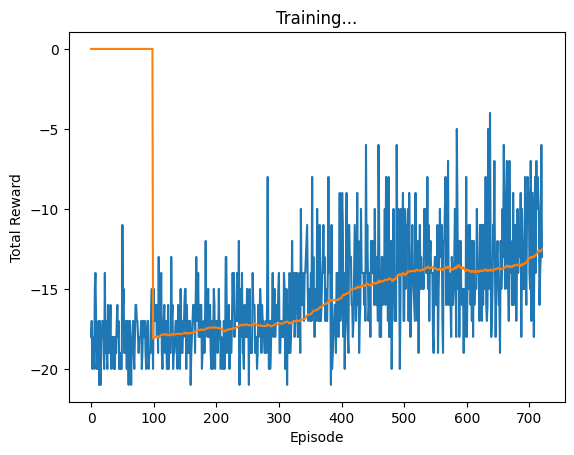

<Figure size 640x480 with 0 Axes>

In [ ]:
# CELL 9: Main Training Loop
print("Starting training...")
start_time = time.time()

num_episodes = 2000
episode_rewards = []
episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_rewards(show_result=False):
    plt.figure(2)
    rewards_t = torch.tensor(episode_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them
    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    print(f"Episode {len(episode_rewards)} / {num_episodes}, "
          f"Avg Reward (Last 100): {rewards_t[-100:].mean():.2f}, "
          f"Epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.3f}, "
          f"Steps: {steps_done}, "
          f"Memory: {len(memory)}")

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

for i_episode in range(num_episodes):
    # Initialize the environment and get the first state
    state, info = env.reset()
    state = torch.tensor(np.array(state), device=device, dtype=torch.uint8)

    total_reward = 0.0

    for t in count():
        # Select and perform an action
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if done:
            next_state = None
        else:
            next_state = torch.tensor(np.array(observation), device=device, dtype=torch.uint8)

        # Store the transition in memory
        # Note: We store the raw state (uint8) to save memory
        memory.push(state, action, next_state, reward, done)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ_target = τ*θ_local + (1 - τ)*θ_target
        if steps_done % TARGET_UPDATE == 0:
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            episode_rewards.append(total_reward)
            if i_episode % 20 == 0: # Plot every 20 episodes
                plot_rewards()
            break

print('Training complete')
print(f"Total training time: {(time.time() - start_time) / 60:.2f} minutes")
plot_rewards(show_result=True)
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [1]:
# CELL 10: Save Model
# Save the trained policy network
torch.save(policy_net.state_dict(), 'pong_dqn_policy_net.pth')

NameError: name 'torch' is not defined

In [ ]:
# CELL 11: Watch the Trained Agent Play!
# This cell creates a new environment, wraps it to record a video,
# runs the agent for one episode, and then displays the video.

print("Recording video of trained agent...")

# Create a new env just for recording
video_env = create_env(render_mode='rgb_array')
# Wrap it in a video recorder
video_env = gym.wrappers.RecordVideo(video_env, 'video', episode_trigger=lambda e: e == 0, name_prefix="pong-agent")

# Use the trained policy net (no exploration)
state, _ = video_env.reset()
done = False
while not done:
    with torch.no_grad():
        state_tensor = torch.tensor(np.array(state), device=device, dtype=torch.uint8).unsqueeze(0)
        action = policy_net(state_tensor).max(1)[1].view(1, 1)
    state, reward, terminated, truncated, _ = video_env.step(action.item())
    done = terminated or truncated

video_env.close()
print("Video recording complete.")

# Find the saved video file
import glob
video_file = glob.glob('video/*.mp4')[0]

# Display the video in Colab
mpy.ipython_display(video_file)

Recording video of trained agent...


Exception ignored in: <function RecordVideo.__del__ at 0x7b46b5e27060>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py", line 433, in __del__
    if len(self.recorded_frames) > 0:
           ^^^^^^^^^^^^^^^^^^^^
AttributeError: 'RecordVideo' object has no attribute 'recorded_frames'


Video recording complete.
